<h2>Assignment<h2>

The objective of the assignment is to implement, compare, and discuss the performance of
three algorithms: SARSA, Q-learning, and Double Q-learning in navigating a maze environment, for the
single agent case and for a multi-agent case.

# **GRIDS**

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
class GridworldA:
    def __init__(self, rows=7, cols=10):
        self.rows = rows
        self.cols = cols

        # Define start and goal positions
        self.start = (3, 0)
        self.goal = (3, 7)

        # Define obstacle positions (cells the agent cannot enter)
        self.obstacles = [(1, 5), (2, 5), (3, 5), (4, 5)]

        # Initialize the environment
        self.reset()

    def reset(self):
        # Reset the agent to the start position
        self.agent_pos = self.start
        return self.agent_pos

    def is_terminal(self, state):
        # Check if the current state is the goal state
        return state == self.goal

    def step(self, action):
        # Get current agent position
        x, y = self.agent_pos

        # Apply action: 0 = UP, 1 = DOWN, 2 = LEFT, 3 = RIGHT
        if action == 0: x -= 1
        elif action == 1: x += 1
        elif action == 2: y -= 1
        elif action == 3: y += 1

        # Ensure the new position is within the grid boundaries
        new_pos = (max(0, min(self.rows - 1, x)), max(0, min(self.cols - 1, y)))

        # If the new position is an obstacle, stay in place
        if new_pos in self.obstacles:
            new_pos = self.agent_pos

        # Update agent position
        self.agent_pos = new_pos

        # Return next state, reward, and done flag
        if self.is_terminal(new_pos):
            # Goal reached
            return new_pos, 1, True
        else:
            # Step cost
            return new_pos, -1, False

    def render(self):
        # Initialize the visual grid with empty cells
        grid = [["." for _ in range(self.cols)] for _ in range(self.rows)]

        # Mark obstacle positions
        for x, y in self.obstacles:
            grid[x][y] = "#"

        # Mark start, goal, and current agent position
        sx, sy = self.start
        gx, gy = self.goal
        ax, ay = self.agent_pos
        grid[sx][sy] = "S"
        grid[gx][gy] = "G"
        if self.agent_pos != self.start and self.agent_pos != self.goal:
            grid[ax][ay] = "A"

        # Print the grid
        for row in grid:
            print(" ".join(row))
        print()

In [ ]:
class GridworldB:
    def __init__(self, rows=7, cols=10):
        self.rows = rows
        self.cols = cols

        # Define start and goal positions
        self.start = (3, 0)
        self.goal = (3, 7)

        # Wind strength per column: how many cells the agent is pushed upwards
        self.wind_strength = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

        # Initialize the environment
        self.reset()

    def reset(self):
        # Reset the agent to the start position
        self.agent_pos = self.start
        return self.agent_pos

    def is_terminal(self, state):
        # Check if the agent has reached the goal state
        return state == self.goal

    def step(self, action):
        # Get current agent position
        x, y = self.agent_pos

        # Apply chosen action: 0 = UP, 1 = DOWN, 2 = LEFT, 3 = RIGHT
        if action == 0: x -= 1
        elif action == 1: x += 1
        elif action == 2: y -= 1
        elif action == 3: y += 1

        # Clamp y to stay within grid limits BEFORE applying wind
        y = max(0, min(self.cols - 1, y))

        # Apply wind effect: push the agent upward based on column
        wind = self.wind_strength[y]
        x -= wind

        # Clamp final position to stay within grid boundaries
        new_x = max(0, min(self.rows - 1, x))
        new_y = max(0, min(self.cols - 1, y))
        self.agent_pos = (new_x, new_y)

        # Check if the agent reached the goal
        if self.is_terminal(self.agent_pos):
            # Goal reached: +1 reward
            return self.agent_pos, 1, True
        else:
            # Step cost: -1 reward
            return self.agent_pos, -1, False

    def render(self):
        # Create a grid filled with dots
        grid = [["." for _ in range(self.cols)] for _ in range(self.rows)]

        # Place start, goal, and agent on the grid
        for x in range(self.rows):
            for y in range(self.cols):
                if (x, y) == self.start:
                    grid[x][y] = "S"
                elif (x, y) == self.goal:
                    grid[x][y] = "G"
                elif (x, y) == self.agent_pos:
                    grid[x][y] = "A"

        # Print the grid row by row
        for row in grid:
            print(" ".join(row))

        # Add spacing, then print wind strength per column
        print()
        print(" ".join(str(w) for w in self.wind_strength))
        print()

In [ ]:
env_a = GridworldA()
env_b = GridworldB()

print("Gridworld A")
env_a.render()

print("Gridworld B")
env_b.render()

Gridworld A
. . . . . . . . . .
. . . . . # . . . .
. . . . . # . . . .
S . . . . # . G . .
. . . . . # . . . .
. . . . . . . . . .
. . . . . . . . . .

Gridworld B
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
S . . . . . . G . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .

0 0 0 1 1 1 2 2 1 0



# **Algorithms**

**Q-Learning**

In [ ]:
class QLearningAgent:
    def __init__(self, env, alpha=0.5, epsilon=0.5, gamma=0.9):
        self.env = env
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.actions = [0, 1, 2, 3]

        # Initialize Q-table
        self.q_table = {}
        for i in range(env.rows):
            for j in range(env.cols):
                self.q_table[(i, j)] = [0 for _ in self.actions]

    def choose_action(self, state):
        # ε-greedy strategy
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(self.actions)
        else:
            return int(np.argmax(self.q_table[state]))

    def learn(self, episodes=500, render_each_step=False, convergence_threshold=25, window_size=25):
        episode_steps = []
        convergence_episode = None

        for ep in range(episodes):
            state = self.env.reset()
            done = False
            steps = 0

            while not done:
                if render_each_step:
                    print(f"Episode {ep + 1}, Step {steps + 1}")
                    self.env.render()

                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)

                # Q-learning update
                max_q_next = max(self.q_table[next_state])
                td_target = reward + self.gamma * max_q_next
                td_error = td_target - self.q_table[state][action]
                self.q_table[state][action] += self.alpha * td_error

                state = next_state
                steps += 1

            episode_steps.append(steps)

            # Check convergence: average over last `window_size` episodes is below threshold
            if ep >= window_size:
                avg_recent = np.mean(episode_steps[-window_size:])
                if avg_recent <= convergence_threshold and convergence_episode is None:
                    # mark convergence episode
                    convergence_episode = ep + 1

        # Metrics
        path_efficiency = np.mean(episode_steps[-window_size:])
        robustness = np.std(episode_steps[-window_size:])

        metrics = {
            "steps_per_episode": episode_steps,
            "convergence_episode": convergence_episode,
            "path_efficiency": path_efficiency,
            "robustness": robustness
        }

        return metrics

**Sarsa**

In [ ]:
class SarsaAgent:
    def __init__(self, env, alpha=0.5, epsilon=0.5, gamma=0.9):
        self.env = env
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.actions = [0, 1, 2, 3]

        # Initialize Q-table
        self.q_table = {}
        for i in range(env.rows):
            for j in range(env.cols):
                self.q_table[(i, j)] = [0 for _ in self.actions]

    def choose_action(self, state):
        # ε-greedy action selection
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(self.actions)
        else:
            return int(np.argmax(self.q_table[state]))

    def learn(self, episodes=500, render_each_step=False, convergence_threshold=25, window_size=25):
        episode_steps = []
        convergence_episode = None

        for ep in range(episodes):
            state = self.env.reset()
            action = self.choose_action(state)
            done = False
            steps = 0

            while not done:
                if render_each_step:
                    print(f"Episode {ep + 1}, Step {steps + 1}")
                    self.env.render()

                next_state, reward, done = self.env.step(action)
                next_action = self.choose_action(next_state)

                # SARSA update rule
                td_target = reward + self.gamma * self.q_table[next_state][next_action]
                td_error = td_target - self.q_table[state][action]
                self.q_table[state][action] += self.alpha * td_error

                state = next_state
                action = next_action
                steps += 1

            episode_steps.append(steps)

            # Check convergence
            if ep >= window_size:
                avg_recent = np.mean(episode_steps[-window_size:])
                if avg_recent <= convergence_threshold and convergence_episode is None:
                    convergence_episode = ep + 1

        # Final metrics
        path_efficiency = np.mean(episode_steps[-window_size:])
        robustness = np.std(episode_steps[-window_size:])

        return {
            "steps_per_episode": episode_steps,
            "convergence_episode": convergence_episode,
            "path_efficiency": path_efficiency,
            "robustness": robustness
        }


**Double Q-Learning**

In [ ]:
class DoubleQLearningAgent:
    def __init__(self, env, alpha=0.5, epsilon=0.5, gamma=0.9):
        self.env = env
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.actions = [0, 1, 2, 3]

        # Initialize two Q-tables
        self.q1 = {}
        self.q2 = {}
        for i in range(env.rows):
            for j in range(env.cols):
                self.q1[(i, j)] = [0 for _ in self.actions]
                self.q2[(i, j)] = [0 for _ in self.actions]

    def choose_action(self, state):
        # ε-greedy policy using the sum of Q1 and Q2
        q_sum = np.add(self.q1[state], self.q2[state])
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(self.actions)
        else:
            return int(np.argmax(q_sum))

    def learn(self, episodes=500, render_each_step=False, convergence_threshold=25, window_size=25):
        episode_steps = []
        convergence_episode = None

        for ep in range(episodes):
            state = self.env.reset()
            done = False
            steps = 0

            while not done:
                if render_each_step:
                    print(f"Episode {ep + 1}, Step {steps + 1}")
                    self.env.render()

                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)

                # Double Q-learning update (randomly update Q1 or Q2)
                if random.uniform(0, 1) < 0.5:
                    next_action = np.argmax(self.q1[next_state])
                    td_target = reward + self.gamma * self.q2[next_state][next_action]
                    td_error = td_target - self.q1[state][action]
                    self.q1[state][action] += self.alpha * td_error
                else:
                    next_action = np.argmax(self.q2[next_state])
                    td_target = reward + self.gamma * self.q1[next_state][next_action]
                    td_error = td_target - self.q2[state][action]
                    self.q2[state][action] += self.alpha * td_error

                state = next_state
                steps += 1

            episode_steps.append(steps)

            # Check for convergence
            if ep >= window_size:
                avg_recent = np.mean(episode_steps[-window_size:])
                if avg_recent <= convergence_threshold and convergence_episode is None:
                    convergence_episode = ep + 1

        # Compute metrics
        path_efficiency = np.mean(episode_steps[-window_size:])
        robustness = np.std(episode_steps[-window_size:])

        return {
            "steps_per_episode": episode_steps,
            "convergence_episode": convergence_episode,
            "path_efficiency": path_efficiency,
            "robustness": robustness
        }

# **Task1**

**Gridworld A**

In [ ]:
alpha = 0.8
epsilon = 0.8

episodes = 1000
window_size = 25
convergence_threshold = 60

results = []

# Q-Learning
env_q = GridworldA()
q_agent = QLearningAgent(env_q, alpha=alpha, epsilon=epsilon)
q_metrics = q_agent.learn(
    episodes=episodes,
    render_each_step=False,
    convergence_threshold=convergence_threshold,
    window_size=window_size
)

print("Q-Learning:", q_metrics)

results.append({
    "Algorithm": "Q-Learning",
    "Convergence Episode": q_metrics["convergence_episode"],
    f"Path Efficiency": q_metrics["path_efficiency"],
    f"Robustness": q_metrics["robustness"],
    "Steps": q_metrics["steps_per_episode"]
})

# SARSA
env_s = GridworldA()
sarsa_agent = SarsaAgent(env_s, alpha=alpha, epsilon=epsilon)
sarsa_metrics = sarsa_agent.learn(
    episodes=episodes,
    render_each_step=False,
    convergence_threshold=convergence_threshold,
    window_size=window_size
)

print("Sarsa:", sarsa_metrics)

results.append({
    "Algorithm": "SARSA",
    "Convergence Episode": sarsa_metrics["convergence_episode"],
    f"Path Efficiency": sarsa_metrics["path_efficiency"],
    f"Robustness": sarsa_metrics["robustness"],
    "Steps": sarsa_metrics["steps_per_episode"]
})

# Double Q-Learning
env_dq = GridworldA()
double_q_agent = DoubleQLearningAgent(env_dq, alpha=alpha, epsilon=epsilon)
double_q_metrics = double_q_agent.learn(
    episodes=episodes,
    render_each_step=False,
    convergence_threshold=convergence_threshold,
    window_size=window_size
)

print("Double Q-Learning:", double_q_metrics)

results.append({
    "Algorithm": "Double Q-Learning",
    "Convergence Episode": double_q_metrics["convergence_episode"],
    f"Path Efficiency": double_q_metrics["path_efficiency"],
    f"Robustness": double_q_metrics["robustness"],
    "Steps": double_q_metrics["steps_per_episode"]
})

Q-Learning: {'steps_per_episode': [186, 292, 116, 206, 215, 150, 22, 107, 246, 59, 297, 226, 32, 104, 73, 32, 58, 55, 108, 78, 31, 41, 38, 39, 160, 37, 44, 39, 75, 56, 47, 125, 125, 42, 76, 47, 33, 34, 105, 166, 114, 117, 38, 27, 60, 53, 70, 126, 64, 46, 76, 44, 63, 52, 36, 35, 107, 46, 20, 43, 34, 85, 107, 49, 50, 43, 51, 121, 26, 43, 73, 26, 46, 47, 39, 36, 35, 26, 94, 81, 24, 54, 44, 61, 81, 86, 35, 46, 46, 66, 50, 61, 40, 63, 162, 158, 67, 46, 43, 104, 48, 96, 81, 72, 53, 35, 31, 144, 143, 65, 55, 27, 73, 93, 70, 131, 78, 66, 27, 111, 50, 63, 52, 111, 79, 49, 36, 23, 74, 75, 39, 49, 117, 66, 45, 130, 44, 71, 50, 57, 189, 32, 56, 49, 176, 69, 21, 68, 109, 62, 43, 97, 33, 30, 73, 58, 63, 23, 75, 39, 72, 47, 93, 67, 169, 41, 89, 128, 23, 225, 85, 55, 53, 54, 32, 32, 27, 54, 33, 98, 48, 92, 22, 40, 71, 45, 52, 63, 45, 42, 51, 83, 104, 82, 87, 45, 65, 81, 50, 48, 151, 30, 53, 43, 69, 122, 71, 118, 20, 55, 130, 28, 42, 23, 122, 94, 34, 61, 129, 35, 91, 54, 106, 43, 156, 104, 17, 17, 164,

In [ ]:
df_a = pd.DataFrame(results)
df_clean_a = df_a.drop(columns=["Steps"])
print(df_clean_a)

           Algorithm  Convergence Episode  Path Efficiency  Robustness
0         Q-Learning                   66            70.76   45.595859
1              SARSA                   80            97.60   69.623559
2  Double Q-Learning                   53            68.08   36.372429


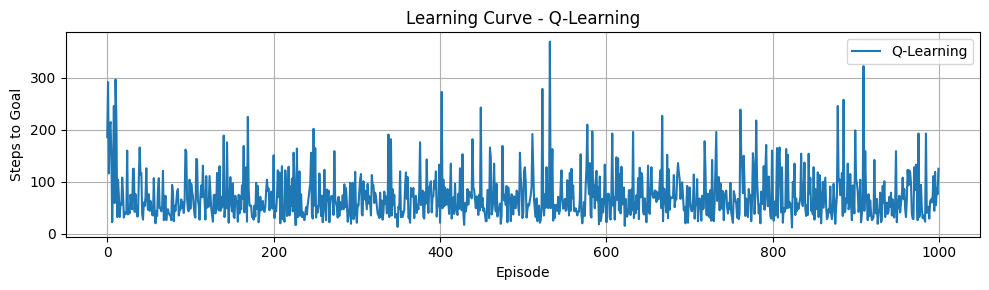

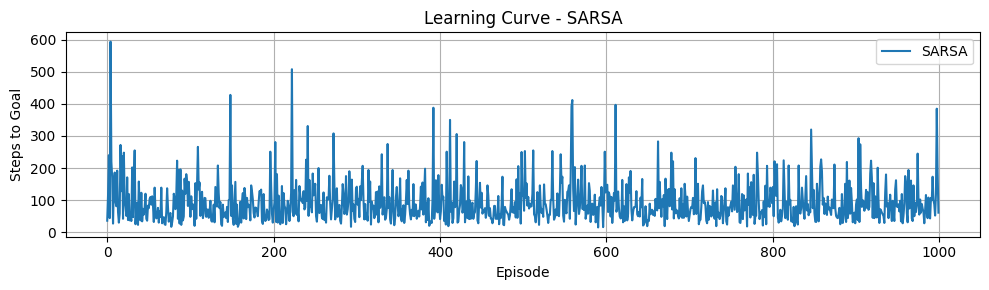

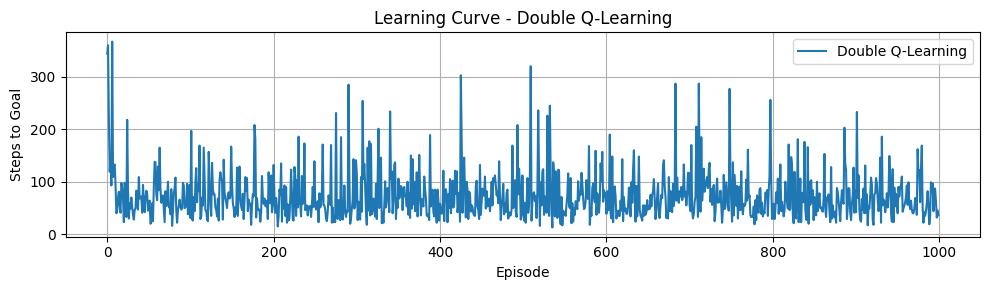

In [ ]:
import matplotlib.pyplot as plt

for result in results:
    plt.figure(figsize=(10, 3))
    plt.plot(result["Steps"], label=result["Algorithm"])
    plt.xlabel("Episode")
    plt.ylabel("Steps to Goal")
    plt.title(f"Learning Curve - {result['Algorithm']}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

**Gridworld B**

In [ ]:
alpha = 0.8
epsilon = 0.8

episodes = 1000
window_size = 25
convergence_threshold = 900

results = []

# Q-Learning
env_q = GridworldB()
q_agent = QLearningAgent(env_q, alpha=alpha, epsilon=epsilon)
q_metrics = q_agent.learn(
    episodes=episodes,
    render_each_step=False,
    convergence_threshold=convergence_threshold,
    window_size=window_size
)

print("Q-Learning:", q_metrics)

results.append({
    "Algorithm": "Q-Learning",
    "Convergence Episode": q_metrics["convergence_episode"],
    f"Path Efficiency": q_metrics["path_efficiency"],
    f"Robustness": q_metrics["robustness"],
    "Steps": q_metrics["steps_per_episode"]
})

# SARSA
env_s = GridworldB()
sarsa_agent = SarsaAgent(env_s, alpha=alpha, epsilon=epsilon)
sarsa_metrics = sarsa_agent.learn(
    episodes=episodes,
    render_each_step=False,
    convergence_threshold=convergence_threshold,
    window_size=window_size
)

print("Sarsa:", sarsa_metrics)

results.append({
    "Algorithm": "SARSA",
    "Convergence Episode": sarsa_metrics["convergence_episode"],
    f"Path Efficiency": sarsa_metrics["path_efficiency"],
    f"Robustness": sarsa_metrics["robustness"],
    "Steps": sarsa_metrics["steps_per_episode"]
})

# Double Q-Learning
env_dq = GridworldB()
double_q_agent = DoubleQLearningAgent(env_dq, alpha=alpha, epsilon=epsilon)
double_q_metrics = double_q_agent.learn(
    episodes=episodes,
    render_each_step=False,
    convergence_threshold=convergence_threshold,
    window_size=window_size
)

print("Double Q-Learning:", double_q_metrics)

results.append({
    "Algorithm": "Double Q-Learning",
    "Convergence Episode": double_q_metrics["convergence_episode"],
    f"Path Efficiency": double_q_metrics["path_efficiency"],
    f"Robustness": double_q_metrics["robustness"],
    "Steps": double_q_metrics["steps_per_episode"]
})

Q-Learning: {'steps_per_episode': [3478, 1228, 140, 816, 161, 277, 988, 1179, 173, 1513, 400, 216, 89, 1584, 165, 103, 535, 542, 394, 715, 132, 1084, 308, 1180, 174, 264, 115, 244, 585, 511, 691, 50, 154, 150, 513, 65, 116, 615, 536, 300, 654, 313, 1024, 1066, 123, 463, 1046, 157, 283, 264, 466, 363, 470, 172, 259, 326, 320, 75, 95, 410, 250, 434, 80, 339, 644, 898, 122, 570, 560, 349, 778, 397, 575, 265, 149, 167, 124, 106, 322, 582, 260, 635, 440, 349, 559, 673, 467, 630, 301, 528, 269, 938, 611, 179, 1515, 529, 135, 319, 271, 121, 156, 159, 277, 98, 685, 781, 271, 310, 174, 123, 114, 597, 320, 156, 263, 241, 173, 68, 426, 97, 166, 229, 918, 849, 106, 859, 113, 143, 244, 527, 629, 118, 371, 188, 192, 258, 273, 775, 94, 408, 532, 88, 63, 206, 329, 508, 113, 356, 755, 113, 201, 747, 518, 399, 190, 1242, 432, 196, 522, 62, 287, 149, 266, 459, 159, 275, 243, 362, 561, 173, 414, 104, 423, 89, 618, 685, 111, 300, 245, 484, 139, 204, 112, 76, 54, 163, 122, 111, 131, 252, 418, 72, 202, 412, 

In [ ]:
df_b = pd.DataFrame(results)
df_clean_b = df_b.drop(columns=["Steps"])
print(df_clean_b)

           Algorithm  Convergence Episode  Path Efficiency  Robustness
0         Q-Learning                   26           396.00  380.063995
1              SARSA                  190          1232.60  819.228369
2  Double Q-Learning                   26           350.96  305.350354


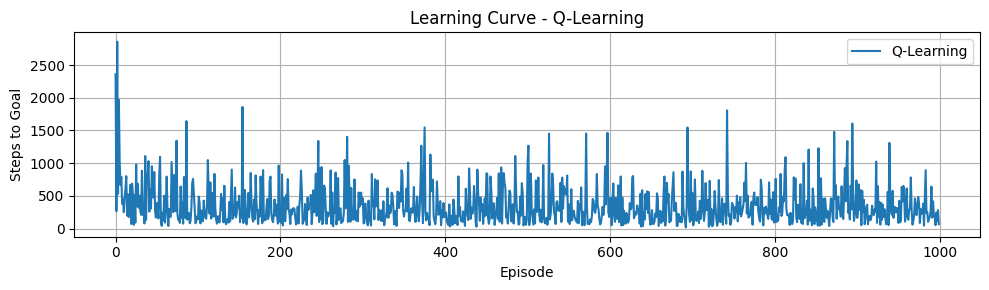

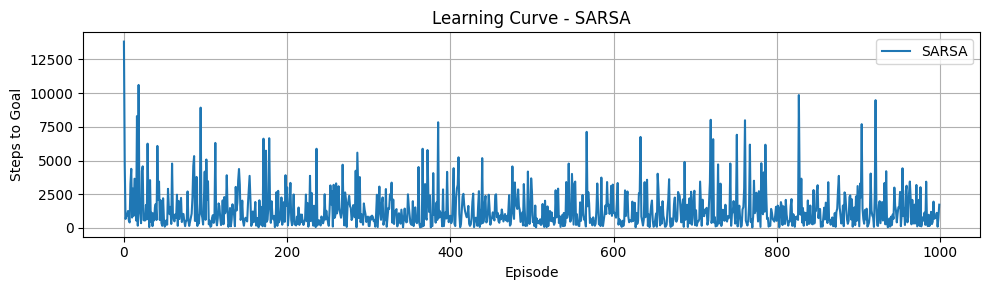

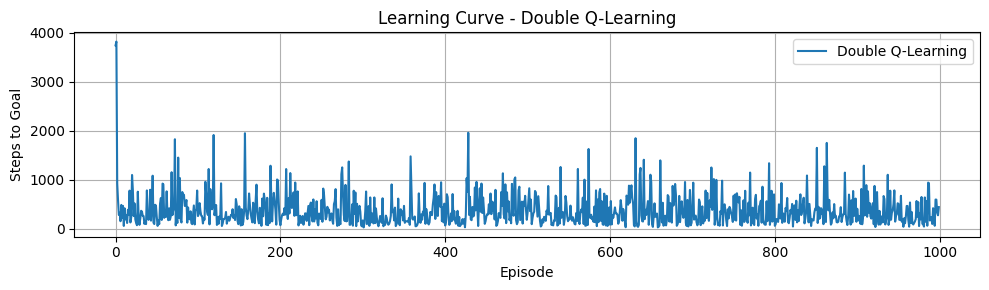

In [ ]:
import matplotlib.pyplot as plt

for result in results:
    plt.figure(figsize=(10, 3))
    plt.plot(result["Steps"], label=result["Algorithm"])
    plt.xlabel("Episode")
    plt.ylabel("Steps to Goal")
    plt.title(f"Learning Curve - {result['Algorithm']}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

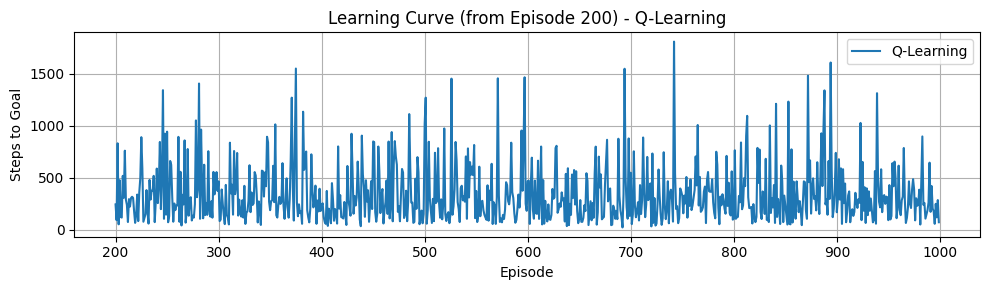

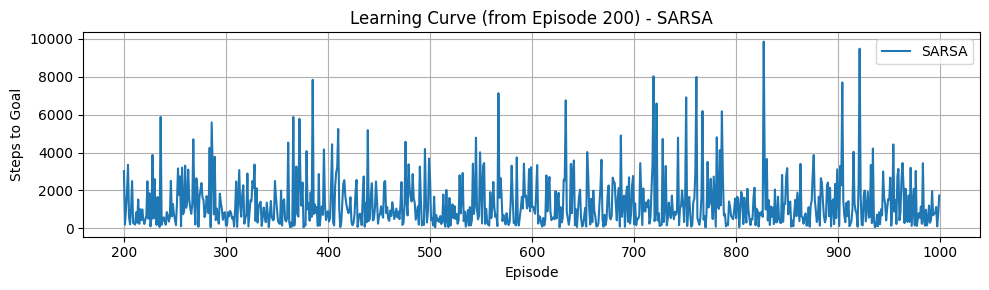

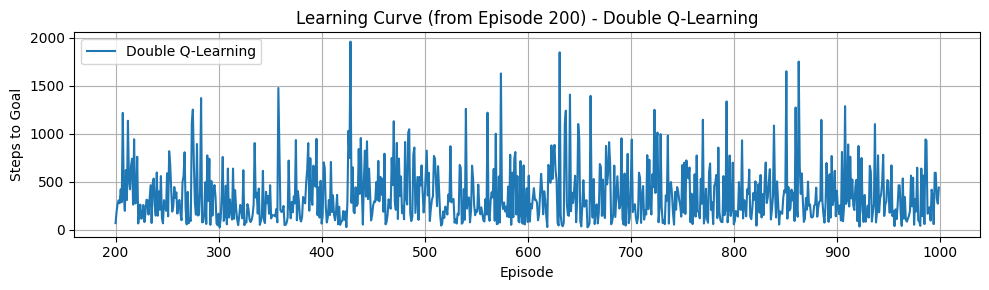

In [ ]:
import matplotlib.pyplot as plt

for result in results:
    plt.figure(figsize=(10, 3))
    steps_trimmed = result["Steps"][200:]
    episodes = list(range(200, 200 + len(steps_trimmed)))

    plt.plot(episodes, steps_trimmed, label=result["Algorithm"])
    plt.xlabel("Episode")
    plt.ylabel("Steps to Goal")
    plt.title(f"Learning Curve (from Episode 200) - {result['Algorithm']}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# **Task 2**

**Multi Agent Gridworld B**

In [ ]:
class MultiAgentGridworldB:
    def __init__(self, n_agents=3, rows=7, cols=10):
        self.rows = rows
        self.cols = cols
        self.n_agents = n_agents
        self.start = (3, 0)
        self.goal = (3, 7)
        self.wind_strength = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
        self.reset()

    def reset(self):
        self.agent_positions = [self.start for _ in range(self.n_agents)]
        self.terminated = [False for _ in range(self.n_agents)]
        return self.agent_positions

    def is_terminal(self, pos):
        return pos == self.goal

    def step(self, actions):
        next_positions = []
        rewards = []
        dones = []

        for idx, action in enumerate(actions):
            if self.terminated[idx]:
                next_positions.append(self.agent_positions[idx])
                rewards.append(0)
                dones.append(True)
                continue

            x, y = self.agent_positions[idx]

            if action == 0: x -= 1
            elif action == 1: x += 1
            elif action == 2: y -= 1
            elif action == 3: y += 1

            y = max(0, min(self.cols - 1, y))
            wind = self.wind_strength[y]
            x -= wind
            new_x = max(0, min(self.rows - 1, x))
            new_y = y

            new_pos = (new_x, new_y)
            next_positions.append(new_pos)

            if new_pos == self.goal:
                # reward will be computed jointly later
                rewards.append(0)
                dones.append(True)
                self.terminated[idx] = True
            else:
                rewards.append(-1)
                dones.append(False)

        # Cooperative reward adjustment
        if all(self.terminated):
            if len(set(next_positions)) == 1:
                # All agents arrived at the same time step
                rewards = [10] * self.n_agents
            else:
                # Agents arrived at different time steps
                rewards = [-0.5] * self.n_agents

        self.agent_positions = next_positions
        return next_positions, rewards, dones

    def render(self):
        grid = [["." for _ in range(self.cols)] for _ in range(self.rows)]

        for idx, pos in enumerate(self.agent_positions):
            x, y = pos
            if pos == self.goal:
                continue
            grid[x][y] = str(idx + 1)

        sx, sy = self.start
        gx, gy = self.goal
        grid[sx][sy] = "S"
        grid[gx][gy] = "G"

        for row in grid:
            print(" ".join(row))
        print()
        print(" ".join(str(w) for w in self.wind_strength))
        print()

In [ ]:
env_multi = MultiAgentGridworldB()

print("Multi Agent Gridworld")
env_multi.render()

Multi Agent Gridworld
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
S . . . . . . G . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .

0 0 0 1 1 1 2 2 1 0



**Multi Agent Q-Learning**

In [ ]:
class MultiAgentQLearning:
    def __init__(self, env, alpha=0.5, epsilon=0.5, gamma=0.9, n_agents=3):
        self.env = env
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.n_agents = n_agents
        self.actions = [0, 1, 2, 3]

        self.q_tables = []
        for _ in range(n_agents):
            q_table = {}
            for i in range(env.rows):
                for j in range(env.cols):
                    q_table[(i, j)] = [0 for _ in self.actions]
            self.q_tables.append(q_table)

    def choose_action(self, agent_idx, state):
        # ε-greedy per agent
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(self.actions)
        else:
            return int(np.argmax(self.q_tables[agent_idx][state]))

    def learn(self, episodes=1000, render_each=False, convergence_threshold=50, window_size=25):
        episode_steps = []
        convergence_episode = None

        for ep in range(episodes):
            states = self.env.reset()
            dones = [False] * self.n_agents
            steps = 0

            if render_each:
                print(f"\nEpisode {ep+1}")

            while not all(dones):
                actions = [self.choose_action(i, states[i]) for i in range(self.n_agents)]
                next_states, rewards, dones = self.env.step(actions)

                # Update Q-values for each agent
                for i in range(self.n_agents):
                    if dones[i]:
                        # don't update terminal states
                        continue

                    current_q = self.q_tables[i][states[i]][actions[i]]
                    max_next_q = max(self.q_tables[i][next_states[i]])
                    td_target = rewards[i] + self.gamma * max_next_q
                    td_error = td_target - current_q
                    self.q_tables[i][states[i]][actions[i]] += self.alpha * td_error

                states = next_states
                steps += 1

                if render_each:
                    self.env.render()

            episode_steps.append(steps)

            # Check convergence
            if ep >= window_size:
                avg_recent = np.mean(episode_steps[-window_size:])
                if avg_recent <= convergence_threshold and convergence_episode is None:
                    convergence_episode = ep + 1

        # Final metrics
        return {
            "steps_per_episode": episode_steps,
            "convergence_episode": convergence_episode,
            "avg_final_steps": np.mean(episode_steps[-window_size:]),
            "robustness": np.std(episode_steps[-window_size:])
        }

In [ ]:
alpha = 0.2
epsilon = 0.2

episodes = 1000
window_size = 25
convergence_threshold = 50

env = MultiAgentGridworldB()
agent = MultiAgentQLearning(env, alpha=alpha, epsilon=epsilon)

metrics = agent.learn(
    episodes=episodes,
    render_each=False,
    convergence_threshold=convergence_threshold,
    window_size=window_size
)

print("Multi Agent Q-Learning:", metrics)
print()
print("Convergence:", metrics["convergence_episode"])
print("Path efficiency:", metrics["avg_final_steps"])
print("Robustness:", metrics["robustness"])

Multi Agent Q-Learning: {'steps_per_episode': [2548, 1288, 376, 739, 488, 834, 362, 217, 179, 268, 199, 155, 356, 95, 404, 286, 323, 286, 215, 108, 298, 108, 110, 96, 172, 308, 92, 228, 182, 138, 403, 104, 191, 92, 65, 140, 260, 173, 65, 74, 320, 156, 82, 192, 128, 161, 186, 169, 156, 164, 143, 276, 117, 82, 203, 165, 52, 93, 132, 85, 133, 196, 149, 253, 192, 129, 101, 88, 141, 366, 91, 92, 89, 122, 55, 60, 92, 108, 72, 94, 123, 101, 80, 115, 81, 402, 110, 118, 125, 64, 49, 118, 142, 94, 115, 136, 66, 100, 94, 138, 70, 62, 109, 89, 75, 104, 179, 73, 128, 73, 96, 95, 77, 95, 91, 77, 100, 134, 70, 86, 117, 94, 82, 96, 120, 75, 66, 118, 52, 62, 91, 59, 55, 122, 71, 97, 80, 69, 54, 50, 98, 62, 91, 53, 133, 64, 73, 72, 83, 87, 98, 76, 73, 91, 64, 65, 70, 97, 112, 39, 108, 56, 103, 63, 68, 63, 103, 117, 96, 62, 41, 67, 84, 54, 41, 41, 75, 106, 38, 69, 82, 63, 44, 93, 85, 80, 74, 135, 36, 91, 118, 88, 57, 55, 57, 70, 100, 75, 77, 79, 95, 75, 121, 127, 76, 81, 55, 41, 101, 74, 44, 83, 43, 68, 

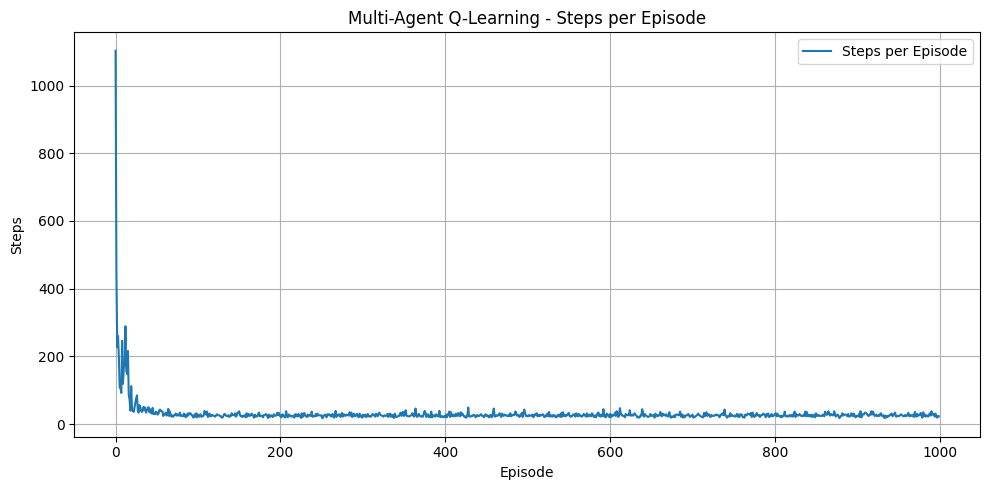

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(metrics["steps_per_episode"], label="Steps per Episode")
plt.title("Multi-Agent Q-Learning - Steps per Episode")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

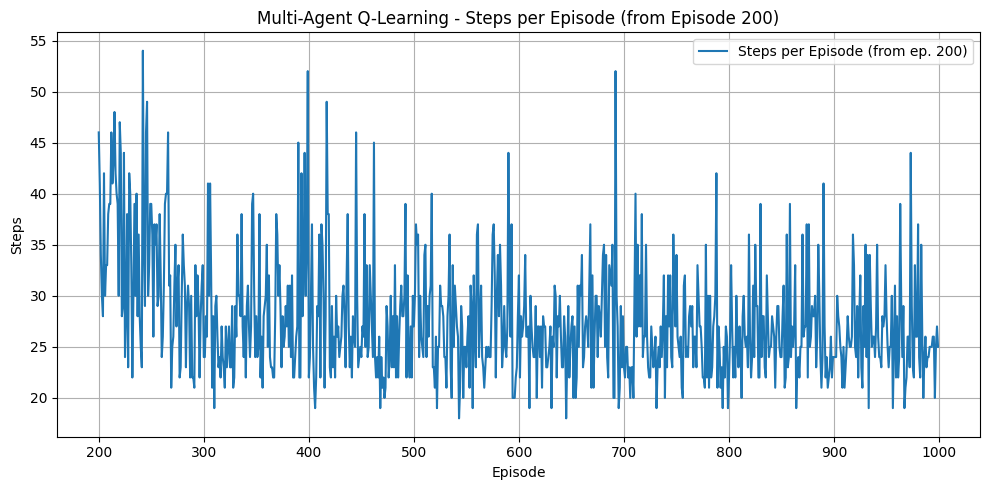

In [ ]:
plt.figure(figsize=(10, 5))

steps_trimmed = metrics["steps_per_episode"][200:]
episodes = list(range(200, 200 + len(steps_trimmed)))

plt.plot(episodes, steps_trimmed, label="Steps per Episode (from ep. 200)")
plt.title("Multi-Agent Q-Learning - Steps per Episode (from Episode 200)")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()